## psf_image_conv_compareSFandnonSF
Script that runs the image convolution on the EAGLE projections.  Use the profiles that are approximately the Dragonfly PSF: double Moffat with Aureole.

Want to convolve the simulation before reducing to the Dragonfly resolution...

__Input:__<br>
paths to .npz files that are both non-SF and SF

__Output:__<br>
maps of the emission with the PSF convolution for SF and nonSF<br>
comparison of SB profiles with the PSF convolution for SF and nonSF

In [1]:
%run 'psf_image_conv.ipynb'

In [4]:
import os

def loaddata(machine):
    homedir=''
    if machine=='chinook':
        homedir='/Users/lokhorst/Eagle/'
    elif machine=='coho':
        homedir='/Users/deblokhorst/eagle/SlicesFromNastasha/'
    ## Add the path to where the raw data is kept on your computer here
    
    files_SF_28 = [homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5__fromSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen17.5__fromSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen7.5__fromSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen2.5__fromSFR.npz']

    files_noSF_28 = [homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_noSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen17.5_noSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen7.5_noSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen2.5_noSFR.npz']
    
    file_SF_28 = homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_20slice_total_fromSFR.npz'
    file_noSF_28 = homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_20slice_total_noSFR.npz'

    if os.path.isfile(file_SF_28):
        print 'Total fromSFR file exists, loading now...'
        halpha_fromSF = np.load(file_SF_28)['arr_0']
    else:
        print 'Total fromSFR file doesnt exist, making it now...'
        halpha_fromSF = np.load(files_SF_28[0])['arr_0']
        for filename in files_SF_28[1:]:
            print 'adding: '+filename
            halpha_fromSF = np.log10(10**halpha_fromSF + 10**(np.load(filename)['arr_0']))
        print 'Saving total fromSFR file to: %s'%file_SF_28
        np.savez(file_SF_28,halpha_fromSF)

    if os.path.isfile(file_noSF_28):
        print 'Total noSFR file exists, loading now...'
        halpha_noSF = np.load(file_noSF_28)['arr_0']
    else:
        print 'Total noSFR file doesnt exist, making it now...'
        halpha_noSF = np.load(files_noSF_28[0])['arr_0']
        for filename in files_noSF_28[1:]:
            print 'adding: '+filename
            halpha_noSF = np.log10(10**halpha_noSF + 10**(np.load(filename)['arr_0']))
        print 'Saving total noSFR file to: %s'%file_noSF_28
        np.savez(file_noSF_28,halpha_noSF)

    return halpha_fromSF,halpha_noSF

In [5]:
halpha_fromSF,halpha_noSF = loaddata('chinook')

Total fromSFR file exists, loading now...
Total noSFR file exists, loading now...


In [6]:
halpha_total = np.log10(10**halpha_fromSF + 10**halpha_noSF)

I want to just crop out a smaller region from the box, though, let's extract approximately *four times* the Dragonfly FOV at 50 Mpc (but has to be square because that's what the image convolution script expects).  Making it bigger than the Dragonfly FOV because the FFT does a periodic thing (of course) so the edges are gonna be funky.  Wanna crop those out.

In [12]:
import get_halpha_SB
%run 'extract_FOV.ipynb'
%run 'load_data.ipynb'

In [23]:
distance = '50Mpc'; z = 0.0115;
resolution = find_output_resolution(distance,True)
fwhm = 3.0*arcsec

The resolution of the raw simulation at 50Mpc is 13.0357429643.


In [24]:
data_tuple = changeres(distance,resolution,halpha_total)
print data_tuple

Will reduce resolution by a factor of 1.0.
(array([[-2.62077165, -2.62564492, -2.63008714, ..., -2.60400987,
        -2.60988569, -2.61549926],
       [-2.61682892, -2.62165117, -2.62603855, ..., -2.60022879,
        -2.60604382, -2.61160588],
       [-2.61321545, -2.61798644, -2.62232208, ..., -2.59680223,
        -2.60254669, -2.60804701],
       ..., 
       [-2.63436723, -2.63937879, -2.64398909, ..., -2.61722207,
        -2.62324286, -2.62897539],
       [-2.62957716, -2.63454533, -2.63909984, ..., -2.61254859,
        -2.61852527, -2.62422156],
       [-2.62503099, -2.62995338, -2.63445163, ..., -2.60812998,
        -2.61405802, -2.61971521]], dtype=float32), 32000.0, 1.0)


In [25]:
dragonfly_fov = 1440. #arcsec
factor_bigger = 1.
data_FOV_total, xystarts_out, size_out = extractFOV(data_tuple, None, distance, 
                                                    x_center = 50.5, y_center = 13.5,
                                                    x_angFOV=dragonfly_fov*factor_bigger,
                                                    y_angFOV=dragonfly_fov*factor_bigger)

In [26]:
numpix = data_FOV_total.shape[0]
boxlength = size_out[0]
print numpix, boxlength

110 0.34375


STARTING convolution...
img shape: (110,110), boxlength: 0.34375 Mpc,numpix: 110,z: 0.0115,kernel: 2MoffatAureole,fwhm: 1.45444104333e-05 arcsec. 

af: 0.02,mf: 0.98, m1f: 0.8,beta1: 7.0,beta2: 2.0,d0: 50.0
 Generating the 2Moffat or 2MoffatAureole kernel...

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 2.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:140: RuntimeWarning: invalid value encountered in log10


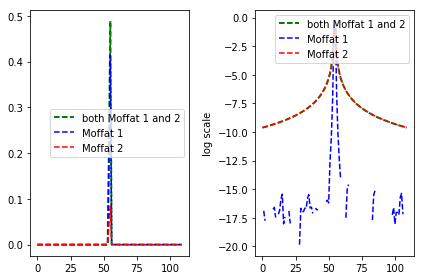

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

FINISHED convolution.


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in power
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in divide


In [27]:
convolved_withSF = conv_image_abr(10**data_FOV_total,boxlength,numpix,z,'2MoffatAureole',fwhm,
                                    debug=False,plotchecks=True)

Will reduce resolution by a factor of 1.0.
STARTING convolution...
img shape: (110,110), boxlength: 0.34375 Mpc,numpix: 110,z: 0.0115,kernel: 2MoffatAureole,fwhm: 1.45444104333e-05 arcsec. 

af: 0.02,mf: 0.98, m1f: 0.8,beta1: 7.0,beta2: 2.0,d0: 50.0
 Generating the 2Moffat or 2MoffatAureole kernel...

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 2.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:140: RuntimeWarning: invalid value encountered in log10


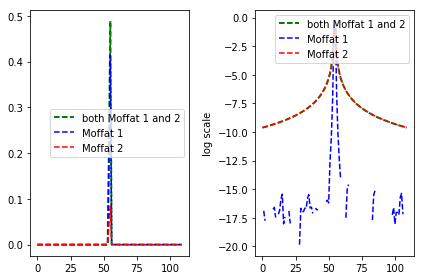

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

FINISHED convolution.


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in power
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in divide


In [28]:
data_tuple = changeres(distance,resolution,halpha_noSF)
data_FOV_noSF, xystarts_out, size_out = extractFOV(data_tuple, None, distance, 
                                                    x_center = 50.5, y_center = 13.5,
                                                    x_angFOV=dragonfly_fov*factor_bigger,
                                                    y_angFOV=dragonfly_fov*factor_bigger)
numpix = data_FOV_noSF.shape[0]
boxlength = size_out[0]
convolved_noSF = conv_image_abr(10**data_FOV_noSF,boxlength,numpix,z,'2MoffatAureole',fwhm,
                                debug=False,plotchecks=True)

The type of size is <type 'list'>
The type of size is <type 'list'>
The type of size is <type 'list'>
The type of size is <type 'list'>


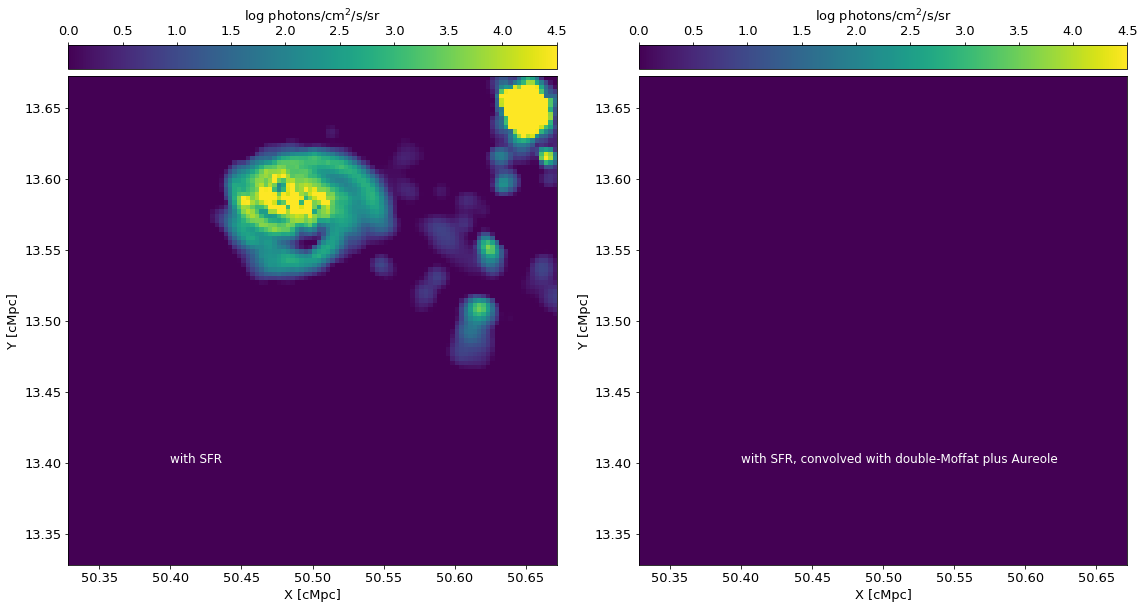

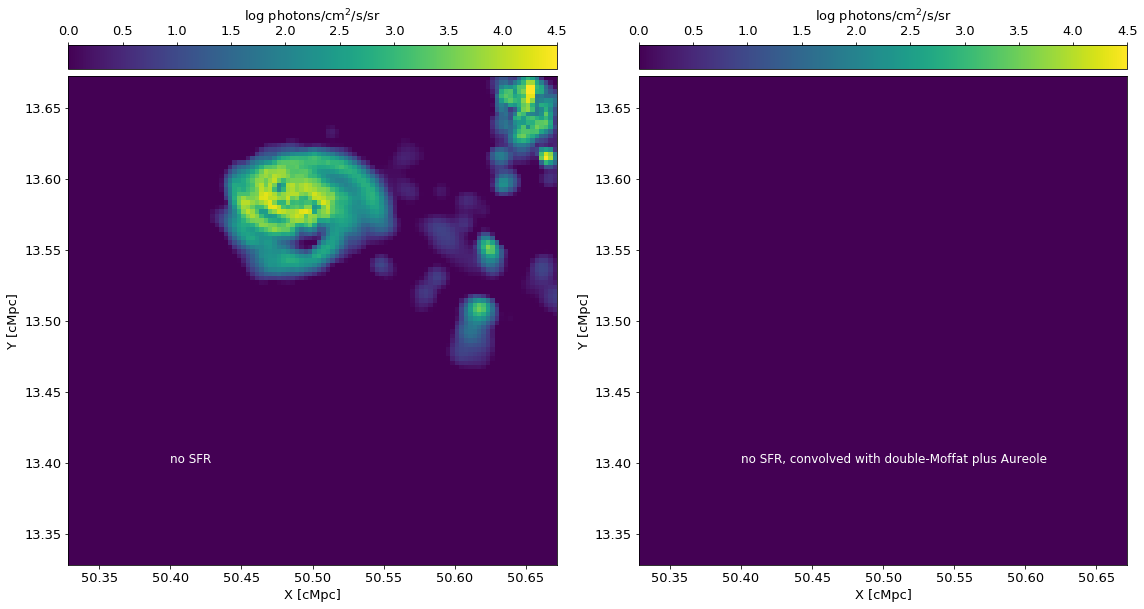

In [29]:
vmin=0; vmax=4.5
# with SFR
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
#get_halpha_SB.
makemap(data_FOV_total,size_out,ax1,xystarts = xystarts_out,Vmin=vmin,Vmax=vmax)
ax1.text(50.40,13.40,'with SFR',color='white',fontsize=12)
#get_halpha_SB.
makemap(np.log10(np.fft.fftshift(convolved_withSF)),size_out,ax2,xystarts = xystarts_out,Vmin=vmin,Vmax=vmax)
ax2.text(50.40,13.40,'with SFR, convolved with double-Moffat plus Aureole',color='white',fontsize=12)
plt.tight_layout()

# no SFR 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
#get_halpha_SB.
makemap(data_FOV_noSF,size_out,ax1,xystarts = xystarts_out,Vmin=vmin,Vmax=vmax)
ax1.text(50.40,13.40,'no SFR',color='white',fontsize=12)
#get_halpha_SB.
makemap(np.log10(np.fft.fftshift(convolved_noSF)),size_out,ax2,xystarts = xystarts_out,Vmin=vmin,Vmax=vmax)
ax2.text(50.40,13.40,'no SFR, convolved with double-Moffat plus Aureole',color='white',fontsize=12)
plt.tight_layout()

In [21]:
def makemap(data,size,ax,colmap='viridis',xystarts = [0.,0.],title = '',colorbar=True,mockobs=False,labelaxes=True,label='',Vmin = None, Vmax = None):
    fontsize=13
    #xystarts = [0.,0.] # lower left origin of the plot
    
    if mockobs:
        clabel = r'log signal (photons)'
    else:
        clabel = r'log photons/cm$^2$/s/sr'
    
    if type(size) == float or type(size) == int:
        print('The type of size is '+str(type(size)))
        xsize = size
        ysize = size
    else:
        print('The type of size is '+str(type(size)))
        xsize = size[0]
        ysize = size[1]
    
    #fig = plt.figure(figsize = (5.5, 5.)) # large size just as a trick to get higher resolution
    #fig = plt.figure(figsize = (11., 10.))
    #ax = plt.subplot(111)
    
    if labelaxes:
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
        #ax.xaxis.set_label_position('top') 
        ax.xaxis.set_label_position('bottom') 
        #ax.xaxis.tick_top()
        #ax.minorticks_on()
    else:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    
    colmap = 'viridis' #'afmhot'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    
    # nearest neighbour interpolation does not do any averaging, it just picks the nearest point and uses that as the value for a specific section in the image
    img = ax.imshow(data.T,extent=(xystarts[0],xystarts[0]+xsize,xystarts[1],xystarts[1]+ysize),origin='lower', 
                    cmap=cm.get_cmap(colmap),interpolation='nearest', vmin = Vmin, vmax=Vmax)
    
    #plt.title(label,fontsize=fontsize)
    div = axgrid.make_axes_locatable(ax)
        
    if colorbar:
        #cax = div.append_axes("right",size="5%",pad=0.1)
        
        # bottom color bar:
        #cax = div.append_axes("bottom",size="15%",pad=0.1)
        #cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
        
        # top color bar:
        cax = div.append_axes("top",size="5%",pad=0.1)
        cbar = plt.colorbar(img, cax=cax,orientation='horizontal')

        cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
        cbar.ax.xaxis.set_label_position('top')      
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.solids.set_edgecolor("face")
        #cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)
    
    font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'bold',
        'size': 12,
        }
    
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
